<a href="https://colab.research.google.com/github/sarathchandrikak/Machine-Learning/blob/main/BERT_implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install transformers[torch]


In [2]:
import transformers
import accelerate

print(transformers.__version__)
print(accelerate.__version__)

4.35.2
0.24.1


In [3]:
! pip install datasets

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [5]:
from datasets import load_dataset
dataset = load_dataset("multi_news")
print(f"Features: {dataset['train'].column_names}")

Features: ['document', 'summary']


In [6]:
from transformers import BartForConditionalGeneration, AutoTokenizer
model_ckpt = "sshleifer/distilbart-cnn-6-6"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = BartForConditionalGeneration.from_pretrained(model_ckpt)

In [7]:
d_len = [len(tokenizer.encode(s)) for s in dataset["validation"]["document"]]
s_len = [len(tokenizer.encode(s)) for s in dataset["validation"]["summary"]]

Token indices sequence length is longer than the specified maximum sequence length for this model (2331 > 1024). Running this sequence through the model will result in indexing errors


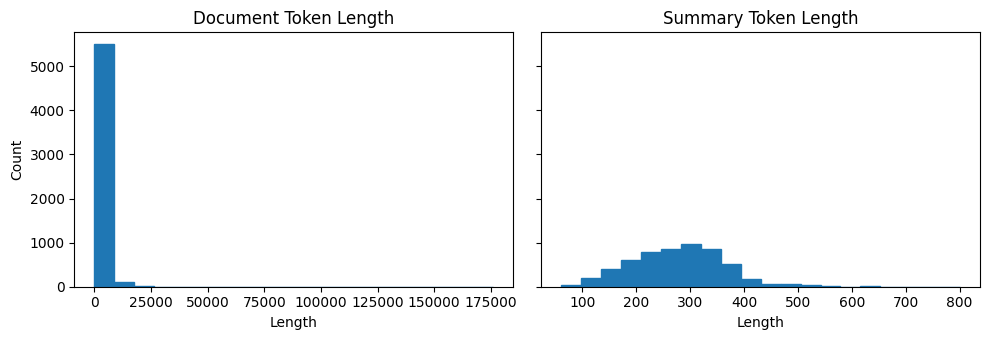

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3.5), sharey=True)
axes[0].hist(d_len, bins=20, color="C0", edgecolor="C0")
axes[0].set_title("Document Token Length")
axes[0].set_xlabel("Length")
axes[0].set_ylabel("Count")
axes[1].hist(s_len, bins=20, color="C0", edgecolor="C0")
axes[1].set_title("Summary Token Length")
axes[1].set_xlabel("Length")
plt.tight_layout()
plt.show()

In [9]:
def convert_examples_to_features(example_batch):
    input_encodings = tokenizer(example_batch["document"], max_length=1024, truncation=True)

    with tokenizer.as_target_tokenizer():
        target_encodings = tokenizer(example_batch["summary"], max_length=256, truncation=True)

    return {"input_ids": input_encodings["input_ids"],
           "attention_mask": input_encodings["attention_mask"],
           "labels": target_encodings["input_ids"]}
dataset_pt = dataset.map(convert_examples_to_features, batched=True)

Map:   0%|          | 0/5622 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:3856: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


In [10]:
from transformers import DataCollatorForSeq2Seq
seq2seq_data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [12]:
from transformers import TrainingArguments, Trainer
training_args = TrainingArguments(output_dir='bart-multi-news', num_train_epochs=1, warmup_steps=500,
                                  per_device_train_batch_size=1, per_device_eval_batch_size=1,
                                  weight_decay=0.01, logging_steps=10, push_to_hub=False,
                                  evaluation_strategy='steps', eval_steps=500, save_steps=1e6,
                                  gradient_accumulation_steps=16)

In [13]:
trainer = Trainer(model=model, args=training_args, tokenizer=tokenizer,
                  data_collator=seq2seq_data_collator,
                  train_dataset=dataset_pt["train"],
                  eval_dataset=dataset_pt["validation"])
trainer.train()

You're using a BartTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss
500,2.650300,2.562931
1000,2.642400,2.486218
1500,2.501300,2.442290
2000,2.467500,2.419623
2500,2.431400,2.413083


TrainOutput(global_step=2810, training_loss=2.586003064600174, metrics={'train_runtime': 5186.3754, 'train_samples_per_second': 8.671, 'train_steps_per_second': 0.542, 'total_flos': 4.541135140302029e+16, 'train_loss': 2.586003064600174, 'epoch': 1.0})

In [21]:
trainer.save_model("trained_model.pt")

In [22]:
! zip -r trained_model.zip trained_model.pt

  adding: trained_model.pt/ (stored 0%)
  adding: trained_model.pt/generation_config.json (deflated 48%)
  adding: trained_model.pt/merges.txt (deflated 53%)
  adding: trained_model.pt/tokenizer_config.json (deflated 76%)
  adding: trained_model.pt/special_tokens_map.json (deflated 85%)
  adding: trained_model.pt/vocab.json (deflated 59%)
  adding: trained_model.pt/config.json (deflated 63%)
  adding: trained_model.pt/model.safetensors (deflated 7%)
  adding: trained_model.pt/tokenizer.json (deflated 72%)
  adding: trained_model.pt/training_args.bin (deflated 51%)


In [23]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [27]:
import os
from google.colab import drive

# Create a folder in the root directory
!mkdir -p "/content/drive/My Drive/My_Folder"


In [28]:
!cp /content/trained_model.zip /content/drive/MyDrive/My_Folder/

In [14]:
sample_text = dataset["test"][1]["document"]
reference = dataset["test"][1]["summary"]
print("Document:")
print(sample_text)
print("\nReference Summary:")
print(reference)

Document:

 
 
 
 UPDATE: 4/19/2001 Read Richard Metzger: How I, a married, middle-aged man, became an accidental spokesperson for gay rights overnight on Boing Boing 
 
 It’s time to clarify a few details about the controversial “Hey Facebook what’s SO wrong with a pic of two men kissing?” story, as it now beginning to be reported in the mainstream media, and not always correctly. 
 
 First of all, with regards to the picture: 
 
 The photo which was used to illustrate my first post about the John Snow Kiss-In is a promotional still from the British soap opera “Eastenders.” It features one of the main characters from the show (Christian Clarke, played by the actor John Partridge- left) and someone else who I don’t know. I am not a regular viewer so I can’t say if the man on the right is an extra or an actual character. 
 
 This picture has itself caused scandal in the UK, as it was a gay kiss that was broadcast before the watershed, and as such led to a number of complaints to the BBC

In [30]:
! pip install torch

In [31]:
import torch

In [32]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [33]:
input_ids = tokenizer(sample_text, max_length=1024, truncation=True, padding='max_length', return_tensors='pt').to(device)

In [34]:
summaries = model.generate(input_ids=input_ids['input_ids'], attention_mask=input_ids['attention_mask'], max_length=256)

In [35]:
decoded_summaries = [tokenizer.decode(s, skip_special_tokens=True, clean_up_tokenization_spaces=True) for s in summaries]

In [36]:
print("\nReference Summary:")
print(reference)
print("\nModel Summary:")
print(decoded_summaries[0])


Reference Summary:
– It turns out Facebook is only guilty of about half of what it’s been accused of in the gay kiss incident. The social networking site apologized yesterday for taking down an image used to promote a “kiss-in” event in London. “The photo in question does not violate our Statement of Rights and Responsibilities, and was removed in error,” the site said in a statement, according to the Advocate. But Facebook did not, as has been reported in several places, take down the kiss-in event itself. Here’s what happened: The photo Facebook took down was posted by the Dangerous Minds blog to promote the event. In its initial write-up about the incident, the blog observed that the page organizing the protest had been taken down. But it was actually the organizer himself who "removed" the event, Dangerous Minds clarified. Organizer Paul Shetler explains that he decided to switch it from a public event to a private one, as "there were starting to be trolls posting abusive nonsense

In [46]:
! pip install rouge-score
! pip install evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.9 MB/s eta 0:00:00


In [47]:
import rouge
import evaluate
rouge_score = evaluate.load("rouge")

In [68]:
rouge = evaluate.load('rouge')
results = rouge.compute(predictions=decoded_summaries[0],
                            references=reference[0: 757])
print(results)


{'rouge1': 0.03830911492734478, 'rouge2': 0.0, 'rougeL': 0.03830911492734478, 'rougeLsum': 0.03830911492734478}


In [58]:
decoded_summaries[0]

'– A photo of two men kissing has been removed from a Facebook page protesting a London pub\'s decision to eject a same-sex couple for kissing, reports the Guardian. "The photo in question does not violate our Statement of Rights and Responsibilities and was removed in error," says a Facebook rep. The page was set up to promote a "gay kiss-in" demonstration in London. The photo was quickly removed and the following e-mail was sent to administrators of Facebook administrators. The decision to remove the photo has prompted scores of people to post their own pictures of gay couples kissing in protest—several in the last few hours alone. "I am not a regular viewer so I can’t say if the man on the right is an extra or an actual character," says one user.'

In [61]:
reference

'– It turns out Facebook is only guilty of about half of what it’s been accused of in the gay kiss incident. The social networking site apologized yesterday for taking down an image used to promote a “kiss-in” event in London. “The photo in question does not violate our Statement of Rights and Responsibilities, and was removed in error,” the site said in a statement, according to the Advocate. But Facebook did not, as has been reported in several places, take down the kiss-in event itself. Here’s what happened: The photo Facebook took down was posted by the Dangerous Minds blog to promote the event. In its initial write-up about the incident, the blog observed that the page organizing the protest had been taken down. But it was actually the organizer himself who "removed" the event, Dangerous Minds clarified. Organizer Paul Shetler explains that he decided to switch it from a public event to a private one, as "there were starting to be trolls posting abusive nonsense on it."'